# Introduction to Decision Trees

The data and scaffolding of code is taken from Harvard's CS109A Course (Introduction to Data Science), all writing is my own. This work hopes to motivate new learner to ML what a decision tree is and how to use it.

If you see any mistakes, errors, or misspellings please let me know. Please be gentle, I am still new at this!

This notebook is as follows:

1. Motivation 
2. Advantages/Disadvantages of a tree based method.
3. Visual walk through of a tree.
4. Algorithm of a tree.
5. Bias/Variance Trade-off & Pruning a tree.

## 1. Motivation: Why use a decision tree?

Any student who has taken and worked with econometric models and real world data is very familiar with issues regarding regression and classification. Most of my day revolves around using OLS, maximum likelihood, and other methods to help predict or better understand latent relationships in policy and education. One issue with economics research at large is its reliance on explaining somewhat complex issues with mostly linear regressions:

* Need to classify something? __Linear probability model or maximum likelihood.__

* Need to explain a linear relationship? __Linear regression.__

* Need to explain a non-linear relationship? __Coerce into linear, then linear regression.__

* Need to explain anything? __Linear regression.__ 

While linear regression is a simple and computationally feasible method, its no catch all for problems an institution faces. Think of this case:

### Example: Predicting College Students.

When relationships deviate from some linear (or exponential) fashion, linear regressions or MLE can fail to identify edge cases when trying to classify outcomes. 

Imagine we're a social network trying to predict which users are college students. We have two features to use, time spent on the website & posts made per day. In reality college students either spend all day on the website and never post or online come online a few times but post frequently. MLE or a linear probability model would have a hard time trying to create parameters that are easily interpretable for this relationship of college students. Especially given the fact college kids reside in opposite corners of the sample space.


Text(0, 0.5, 'Posts Made')

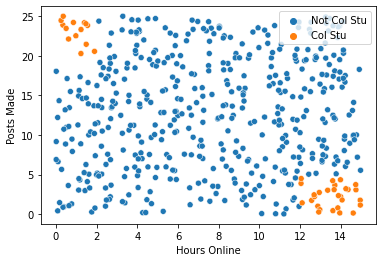

In [7]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

ex_1 = pd.DataFrame(dict(
    hours_online=np.random.uniform(0, 15, size=500),
    posts_made=np.random.uniform(0, 25, size=500),
))

ex_1.loc[(ex_1.hours_online < 2) & (ex_1.posts_made  > 20), 'college_student'] = 1
ex_1.loc[(ex_1.hours_online > 12) & (ex_1.posts_made  < 5), 'college_student'] = 1
ex_1.college_student = ex_1.college_student.fillna(0)


ax = sns.scatterplot(x='hours_online', y='posts_made', hue='college_student', data=ex_1)
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles,['Not Col Stu', 'Col Stu'], loc='upper right')
ax.set_xlabel('Hours Online')
ax.set_ylabel('Posts Made')


### Wouldn't it be nice to be able to not only predict college students effectively but also have a model that can be presented in an intuitive manner? 

<h1><center> In its simplest form, Decision Trees work best for these cases. </center></h1>




------------------------------------------------------------------------------------------------------------------------------------------------



# 2. Advantages/Disadvantages of Decision Trees:

Decision trees have a few strengths:
+ Easy to visualize and interpret. 
+ Able to fit non-linear or complex relationships without a hard to interpret model.
+ Coding wise - easily to implement with varied data types.
+ Flexible tuning to easily increase/decrease variance or bias.

While strong in practical use it can have issues:
- In its simplest form, fails to achieve the same predictive power of OLS or MLE.
- Non-robust, susceptible to small perturbations in training data.
- In it's more complex states it becomes highly uninterpretable.

# 3. Walk through of Decision Tree 

Using our example data we can see that decision tree's can create simple visuals to show the relationship:

* The 0th node (Hours Online <= 3) can be called the __root node__, this is the first split
* The 1st and 4th node can be called the __internal nodes__, these correspond to values where different groups are separated.
* Nodes 2, 3, 5, and 6 are called __leafs__, these are the final buckets that our predictions reside.

In total this tree based visual is easier to interpret than a regression table.

Lets run through an example:

1. Node 0: We split college & non-college on wether they're online less or more than 0.3 hours.
2. Node 1: For people on less than 0.3 hours, we split wether they make less or more than 12.4 posts
3. Leaf 1 (Node 2): For people less than 0.3 hours online and posting less than 12.4 times, we predict they are non-students.
4. Leaf 2 (Node 3): For people with less than 0.3 hours line, but more than 12.4 posts per day, we predict they are student.

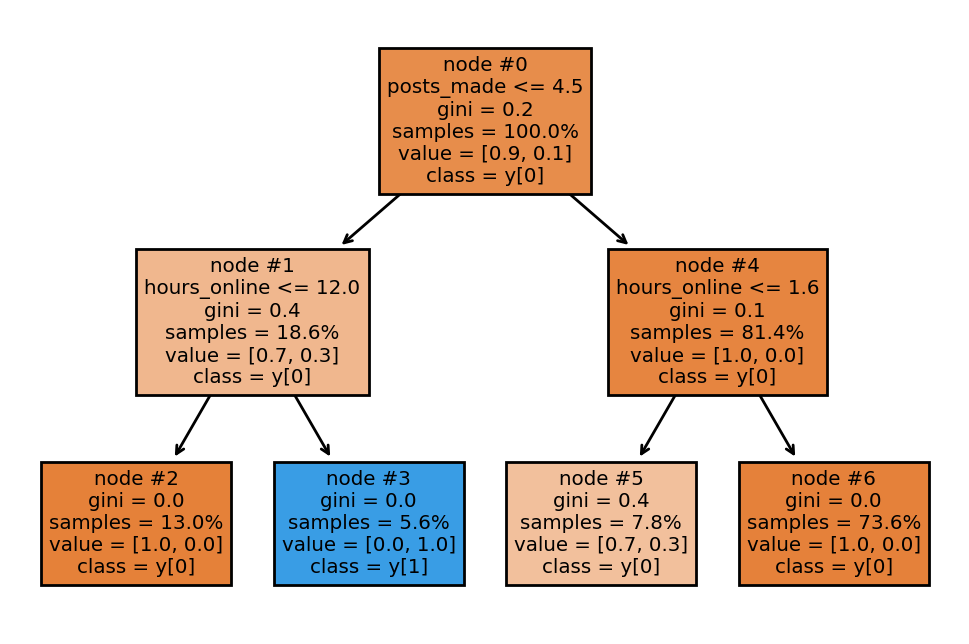

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


dt = DecisionTreeClassifier(max_depth=2)

dt.fit(ex_1[['hours_online', 'posts_made']], ex_1['college_student'])

plt.figure(dpi=200)
plot_tree(dt,
          feature_names=ex_1.columns,
          proportion=True,
          filled=True,
          label = 'all',
          precision=1,
          class_names=True,
          node_ids=True);

Moreover, plotting the tree we can follow how the partition was made:

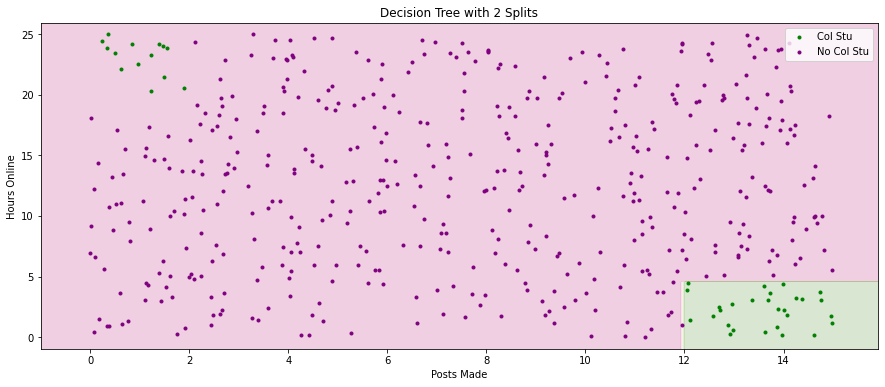

In [9]:
def example(tree, num):
    dt = DecisionTreeClassifier(max_depth=num)
    dt.fit(ex_1[['hours_online', 'posts_made']], ex_1['college_student'])
    y_train =  ex_1['college_student']
    x1_min, x1_max = ex_1['hours_online'].min() - 1, ex_1['hours_online'].max() + 1
    x2_min, x2_max = ex_1['posts_made'].min() - 1, ex_1['posts_made'].max() + 1
    x1x, x2x = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                    np.arange(x2_min, x2_max, 0.1))

    yhat = dt.predict(np.c_[x1x.ravel(), x2x.ravel()]).reshape(x1x.shape)

    fig, ax1 = plt.subplots(1,1,figsize=[15, 6])
    ax1.contourf(x1x, x2x, yhat, alpha=0.2, cmap="PiYG");
    ax1.scatter(ex_1['hours_online'][y_train == 1], ex_1['posts_made'][y_train == 1], marker=".", color="green",
                    label="Col Stu")
    ax1.scatter(ex_1['hours_online'][y_train == 0], ex_1['posts_made'][y_train == 0], marker=".",
                    color="purple", label="No Col Stu")
    ax1.set_ylabel("Hours Online")
    ax1.set_xlabel("Posts Made")
    ax1.set_title(f"Decision Tree with {num} Splits")
    ax1.legend(loc='upper right')
    
example(dt, 2)


Lastly, noting point 3. Making the tree more complex can allow for more flexibility. Notice above that we still can't predict the lower right college students, however with more power comes better prediction over our set of data:

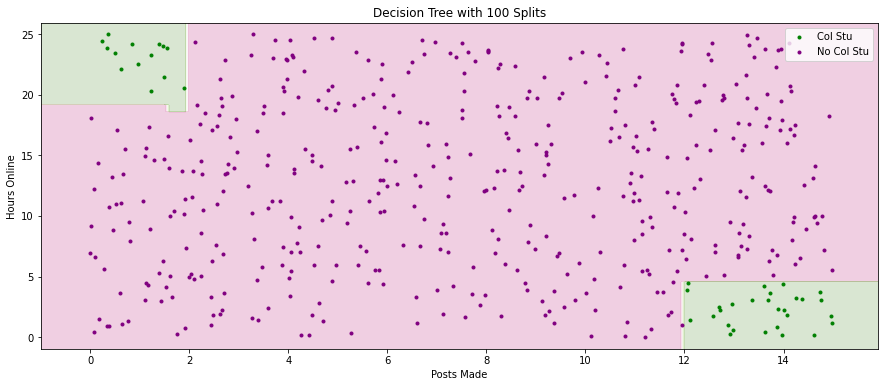

In [10]:
example(dt, 100)

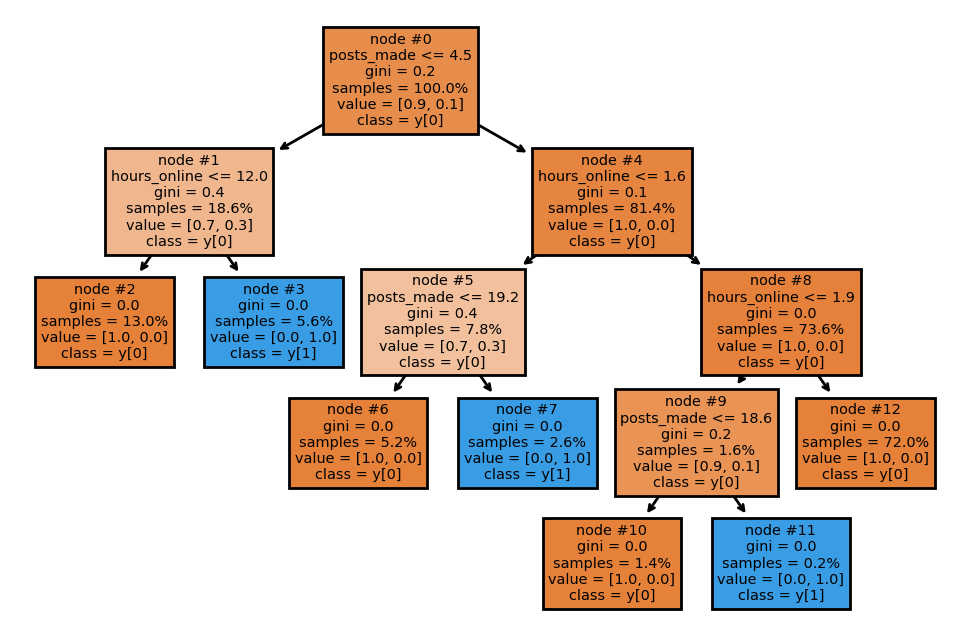

In [11]:
dt = DecisionTreeClassifier(max_depth=100)
dt.fit(ex_1[['hours_online', 'posts_made']], ex_1['college_student'])
plt.figure(dpi=200)
plot_tree(dt,
          feature_names=ex_1.columns,
          proportion=True,
          filled=True,
          label = 'all',
          precision=1,
          class_names=True,
          node_ids=True);

# 4. How does the Decision Tree Work?

### 4.1 TLDR:

While we've seen the graphical version of the tree, its worth digging deeper into the math that surrounds how decision trees function.


On a qualitative level a decision tree simply:
* Takes in a __splitting criterion__ (i.e. whats the preferred way to know which split in the data works best?)
* Takes in a __stopping condition__ (i.e. when should I stop splitting the data and finish?)
* Searches over all features and values within the feature to figure out when to split the data into values, groups, etc...
* Stops the search and split process when the stopping condition is met.

Quantitatively, we first need to define some aspects:

* The predictor space $Z$ can be defined as the set of possible values our features $X = \{x_1, x_2, ... x_n\}$ can take on. For instance we could imagine $X_1 = \{12, 7\}$ for a student online for 12 hours and making 7 posts.
* A partition or split made from the tree can done $M$ times, composed of $R_1, ..., R_m$ regions. For instance, in the first tree we saw $M=2$ splits, composed of $R=2$ regions present.

### 4.2 The splitting criterion

How to split our predictor space depends on the exercise at hand (regression v. classification). However, the decision tree algorithm attempts to ensure that splits are as accurate as possible. Therefore, the optimal split is picked to __minimize loss__. This means the usable criterion are identical loss metrics as we use in OLS or other models.

For regressions this means we might want to select __RMSE__ or __MSE__. Such that for each region $R_m$ we assign a value for all observations $i$ within it $\hat{y}_{iR_m}$. Meaning we want to minimize:
$$
\sum_{m=1}^M\sum_{i \in R_{m}}(y_i - \hat{y}_{iR_m})^2
$$

For classification we have three popular options:

1. __Classification error__: Given our classes $K = \{k_1, k_2, ...k_j\}$, features $X$, we want to split to create $R_m$ on a value $t_x$ that minimizes the error:
$$
Error(i|x,t_x) = 1 - max_k(\hat{p}_{mk}) 
$$ 
Where we have the most $k$ in the region $m$. Where \hat{p}_{mk} is the proportion of training points in $R_m$ labeled class $k$.

2. __GINI purity__: Instead of the classification error which asks how many did we get right or wrong. Gini instead is a measure of purity of each region: 
$$ 
Gini = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})
$$

Where we measure the total variance across all classes. Here if all the classes in region $m$ are indentical then $\hat{p}_{mk} = 1$. So Gini equals 0.

However, if $\hat{p}_{m1} = \hat{p}_{m2} = ... = \hat{p}_{mk}$ then the Gini values approaches one.

3. __Entropy__: Entropy is much like gini, however it uses information gain as a metric:

$$
Entropy = -\sum_{k=1}^K\hat{p}_{mk}log(\hat{p}_{mk})
$$

Like Gini, when $\hat{p}_{mk} = 1$ (or close), the entropy value is close to zero. When \hat{p}_{mk} is similar across classes the value becomes higher. 

In other terms:
* When entropy is low, the distribution of class values is has defined peaks and valleys. Meaning one class value is more probable than others
* When entropy is high, the distribution is more uniform. Meaning all class values are equally probable.


### 4.3 The stopping criterion 

When can we tell the decision tree to stop? Here are some popular methods:

1. Specify the maximum depth of the tree. For instance, I specified 2 or 100 in the previous example.
2. Stop splitting if the split criterion loss function equals zero (we perfectly explain everything in the region).
3. Specify the minimum number of observations in a leaf.
4. Specify the number of leaves in the tree.
5. Specify the gain in purity or decrease in loss for a split to be made.

all of these stopping criterion can be found via cross validation. Picking too loose of a stopping criterion will increase variance as the tree can overfit the training data, creating leaves of 1 observation. Picking too stringent of a stopping criterion can increase bias, making obvious splits impossible based on harsh rules.

### 4.4 CART Algorithm 
The type of decision tree algorithm we see today (and what I learned) is typically called __CART__ (classification and regression tree). Where the process entails:

1. Over $Z$ (or prediction space) iterate over all features $X$.
2. For the iterated feature $x$, calculate the splitting criterion purity/loss for each value $t$.
3. For the value $t$ and feature $x$ which has the best purity/loss, split the prediction space $Z$ into two regions $R_v, R_b$.
4. For each region made, take a consensus on which class $i \in R_v$ is (or which value if regression by taking mean).
5. Over the new region $R_v$, repeat step 1 through 4.
6. Stop the algorithm for the current split once the stopping criterion is met. 

# 5. Bias & Variance of a Tree

Like any machine learning model using a decision tree comes with the trade off between variance & bias, in our case:

* A deep tree (many internal nodes) suffer from high variance: Deep trees allow us to make many regions in our sample space, creating precise boundaries when classifying or regressing. A small deviation from our training data to test data will create large errors.
* A shallow tree suffers from high bias: Shallow trees provide more broad splits, not allowing for precise regions. 